# Code from here https://spark-in.me/post/unet-adventures-part-one-getting-acquainted-with-unet

# another simple example https://www.kaggle.com/toregil/a-lung-u-net-in-keras/code

In [ ]:
import numpy as np
import os
import smtplib
from keras.applications.resnet50 import ResNet50
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import concatenate, Conv3DTranspose, Concatenate
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, Input, BatchNormalization, Lambda, UpSampling3D
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.utils.training_utils import multi_gpu_model
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os

os.environ["CUDA_VISIBLE_DEVICES"]="0" #Comment this line out if you want all GPUS (2 hehe)

def notify_me(msg):
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    with open('/home/tkyono/.emailsettings') as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    server.login(content[0], content[1])
    server.sendmail('DeepLearningBox', '8084460540@vtext.com', msg)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return dice_coef(y_true, y_pred)




In [3]:
def read_hdf5(path, num_images):
    import h5py
    import pylab
    print(path)
    fh = h5py.File(path, 'r')

def show_img(img):
    pylab.imshow(img)
    pylab.colorbar()
    pylab.show()
    
def show_img_zoom(img):
    pylab.imshow(img)
    pylab.axis([1000,2000,1500,2500])
    pylab.colorbar()
    pylab.show()
    
    
import h5py
import pylab  



# Do Phase

# don't forget that we can use [:12] and [14:] for training set.  We can effectively double our training set this way.

In [4]:
num_layers = 12
 
from keras.layers import LeakyReLU
def get_unet():

    inputs = Input((num_layers, 64, 64, 1))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (2, 3, 3), activation=LeakyReLU(), padding='same')(inputs)
    conv1 = Conv3D(64, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (2, 3, 3), activation=LeakyReLU(), padding='same')(pool1)
    conv2 = Conv3D(128, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (2, 3, 3), activation=LeakyReLU(), padding='same')(pool2)
    conv3 = Conv3D(256, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (2, 3, 3), activation=LeakyReLU(), padding='same')(pool3)
    conv4 = Conv3D(512, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (2, 3, 3), activation=LeakyReLU(), padding='same')(pool4)
    conv5 = Conv3D(1024, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (2, 3, 3), activation=LeakyReLU(), padding='same')(up6)
    conv6 = Conv3D(512, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (2, 3, 3), activation=LeakyReLU(), padding='same')(up7)
    conv7 = Conv3D(256, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (2, 3, 3), activation=LeakyReLU(), padding='same')(up8)
    conv8 = Conv3D(128, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (2, 3, 3), activation=LeakyReLU(), padding='same')(up9)
    conv9 = Conv3D(64, (2, 3, 3), activation=LeakyReLU(), padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model


def get_unet(): ########## BEST SO FAR

    inputs = Input((num_layers, 64, 64, 1))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (2, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(1024, (2, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(128, (2, 3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(64, (2, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

def get_unet():

    inputs = Input((num_layers, 64, 64, 1))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

def get_unet():

    inputs = Input((num_layers, 64, 64, 1))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (1, 5, 5), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (1, 5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(up8)
    conv8 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (1, 5, 5), activation='relu', padding='same')(up9)
    conv9 = Conv3D(64, (1, 5, 5), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model


def get_unet():

    inputs = Input((num_layers, 64, 64, 1))
    #bn = BatchNormalization()(inputs)
    conv1 = Conv3D(64, (1, 2, 2), activation='relu', padding='same')(inputs)
    conv1 = Conv3D(64, (1, 2, 2), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling3D(pool_size=(1, 2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    
    conv2 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(pool1)
    conv2 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling3D(pool_size=(1, 2, 2))(conv2)
    pool2 = BatchNormalization()(pool2)

    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling3D(pool_size=(1, 2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)

    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling3D(pool_size=(1, 2, 2))(conv4)
    pool4 = BatchNormalization()(pool4)

    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv3D(1024, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv3DTranspose(512, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv5), conv4], axis=4)
    #up6 = concatenate([UpSampling3D(size=(1, 2, 2))(conv5), conv4])
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv3D(512, (2, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv3DTranspose(256, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv6), conv3], axis=4)
    #up7 = concatenate([UpSampling3D(size=(1, 2, 2))(conv6), conv3])
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv3D(256, (2, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv3DTranspose(128, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv7), conv2], axis=4)
    #up8 = concatenate([UpSampling3D(size=(1, 2, 2))(conv7), conv2])
    conv8 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(up8)
    conv8 = Conv3D(128, (1, 5, 5), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv3DTranspose(64, (1, 2, 2), strides=(1, 2, 2), padding='same')(conv8), conv1], axis=4)
    #up9 = concatenate([UpSampling3D(size=(1, 2, 2))(conv8), conv1], axis=4)
    conv9 = Conv3D(64, (1, 2, 2), activation='relu', padding='same')(up9)
    conv9 = Conv3D(64, (1, 2, 2), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv3D(1, (1, 1, 1), activation='linear')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model


model = get_unet()
plot_model(model, to_file='unet1.png', show_shapes=True)

def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))


train_dir = '/home/tkyono/Desktop/bispectrum_training/*.h5'
val_dir = '/home/tkyono/Desktop/bispectrum_training/validate/*.h5'
batch_size = 8
num_files = 0
for i in glob.glob(train_dir):
    num_files += 1
#print("Found ", num_files, "files")
def generate(d): #changed all REAL to PHASE and all IMAGINARY to MAG
    while True:
        #print("Recycling through files")
        for i in glob.glob(d):
            #print("Opening new file", i)
            hdf5 = h5py.File(i, 'r')
            num_images = len(hdf5['Degraded_amplitude']) // batch_size
            for k in range(num_images):
                Xr = []
                Yr = []
                Xi = []
                Yi = []
                j = batch_size * k
                F1Xi = hdf5['Degraded_amplitude'][j:j + batch_size]
                #print(F1Xi.shape)
                F1Xi = np.reshape(F1Xi, (batch_size, 25, 64,64))
                #print(F1Xi.shape)
                F1Xr = hdf5['Degraded_phase'][j:j + batch_size]
                F1Xr = np.reshape(F1Xr,(batch_size,25, 64,64))
                F1Yi = hdf5['Pristine_amplitude'][j:j + batch_size]
                F1Yi = np.reshape(F1Yi,(batch_size,25, 64,64))
                F1Yr = hdf5['Pristine_phase'][j:j + batch_size]
                F1Yr = np.reshape(F1Yr, (batch_size,25, 64,64))
                #F1Xr = np.moveaxis(F1Xr, 1, 4)
                for i in range(len(F1Xr)):
                    Xr.append(normalize(F1Xr[i])) 
                #F1Yr = np.moveaxis(F1Yr, 1, 4)
                for i in range(len(F1Yr)):
                    Yr.append(normalize(F1Yr[i]))
                #F1Xi = np.moveaxis(F1Xi, 1, 4)
                for i in range(len(F1Xi)):
                    Xi.append(normalize(F1Xi[i]))
                #F1Yi = np.moveaxis(F1Yi, 1, 4)
                for i in range(len(F1Yi)):
                    Yi.append(normalize(F1Yi[i]))
                Xr = np.array(Xr)[:,:12,:,:]    
                Yr = np.array(Yr)[:,:12,:,:]     
                Xi = np.array(Xi)[:,:12,:,:]      
                Yi = np.array(Yi)[:,:12,:,:]    
                yield np.reshape(Xr, (batch_size, num_layers, 64, 64, 1)) , np.reshape(Yr, (batch_size,num_layers,  64, 64, 1))
            hdf5.close()
            
callbacks = [ModelCheckpoint('best_phase', verbose=1, monitor='val_mean_squared_error',save_best_only=True),
            EarlyStopping(monitor='val_mean_squared_error', min_delta=0.00001, patience=2, verbose=1, mode='auto')
           ]

model.compile(optimizer=optimizers.Adam(lr = 1e-3),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
            

model = load_model('best_phase')
model.compile(optimizer=optimizers.Adam(lr = 1e-4),metrics = ['mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)


model = load_model('best_phase')
model.compile(optimizer=optimizers.Adam(lr = 1e-5),metrics = [ 'mean_squared_error'],
              loss = ['mean_squared_error'])        
model.fit_generator(generate(train_dir), epochs = 100, steps_per_epoch = num_files * 1000 // batch_size, callbacks = callbacks,
                    validation_data = generate(val_dir), validation_steps = 1 * 1000 // batch_size)
  




Epoch 1/100
2500/2500 [==============================] - 1570s 628ms/step - loss: 0.2537 - mean_squared_error: 0.2537 - val_loss: 0.2573 - val_mean_squared_error: 0.2573

Epoch 00001: val_mean_squared_error improved from inf to 0.25725, saving model to best_phase
Epoch 2/100
2500/2500 [==============================] - 1562s 625ms/step - loss: 0.2413 - mean_squared_error: 0.2413 - val_loss: 0.2633 - val_mean_squared_error: 0.2633

Epoch 00002: val_mean_squared_error did not improve
Epoch 3/100
2500/2500 [==============================] - 1561s 624ms/step - loss: 0.2302 - mean_squared_error: 0.2302 - val_loss: 0.2717 - val_mean_squared_error: 0.2717

Epoch 00003: val_mean_squared_error did not improve
Epoch 00003: early stopping
Epoch 1/100
2500/2500 [==============================] - 1573s 629ms/step - loss: 0.2390 - mean_squared_error: 0.2390 - val_loss: 0.2584 - val_mean_squared_error: 0.2584

Epoch 00001: val_mean_squared_error did not improve
Epoch 2/100
2500/2500 [================

(8, 5, 5, 64, 64)
(8, 12, 64, 64, 1)
0.8895401
************** i =  0
Predicted


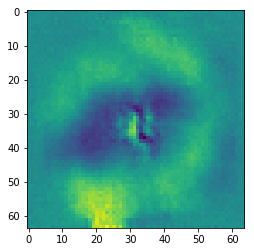

-0.31730676 0.32190204
Noisy


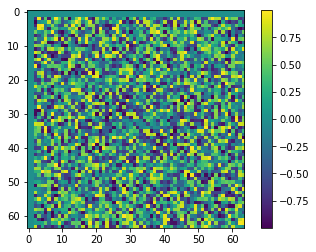

-0.9994002958127335 0.9988273853474446
Pristine


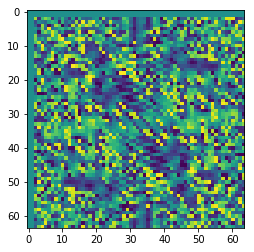

-0.99820599546141 0.9992468766889883
************** i =  1
Predicted


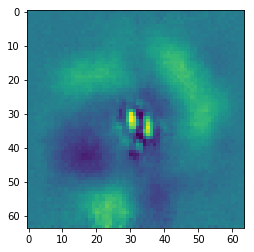

-0.29648918 0.41455042
Noisy


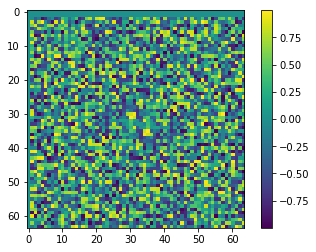

-0.9994894492098997 0.9993869443339941
Pristine


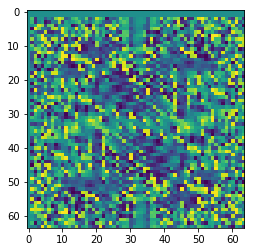

-0.9955055620296199 0.9986059924638897
************** i =  2
Predicted


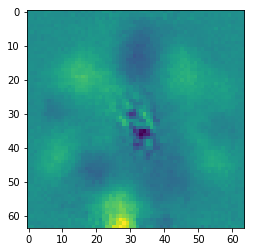

-0.40190566 0.4114197
Noisy


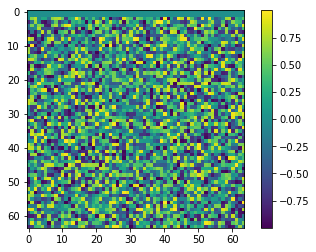

-0.9993394396343458 0.9999678774093763
Pristine


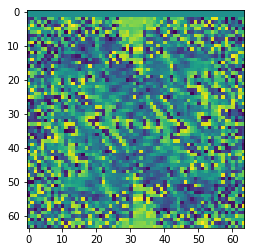

-0.9989650785511104 0.9994979771395364
************** i =  3
Predicted


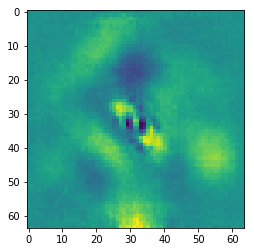

-0.3910954 0.3769532
Noisy


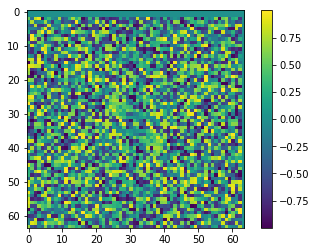

-0.9999051255310127 0.9996322727141485
Pristine


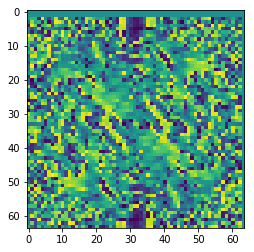

-0.9987512197561448 0.997993098292674
************** i =  4
Predicted


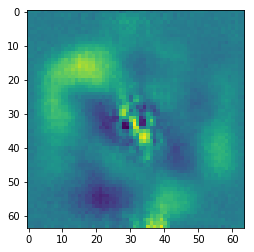

-0.3016953 0.40328133
Noisy


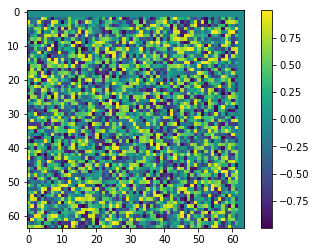

-0.999042493880544 0.9999172168053555
Pristine


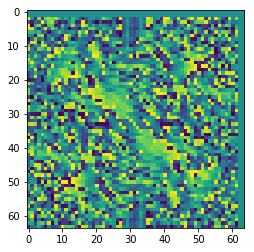

-0.9990927909385451 0.9984343048312302
************** i =  5
Predicted


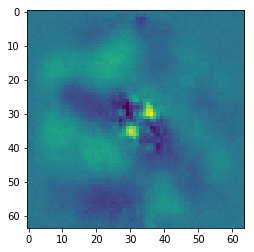

-0.34861413 0.54435337
Noisy


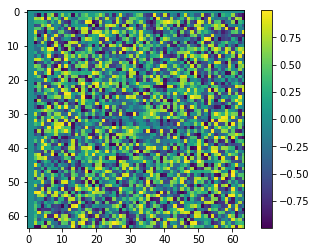

-0.9983448173644331 0.9979490947068229
Pristine


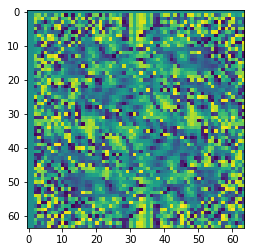

-0.9989423881516941 0.9992355953381419
************** i =  6
Predicted


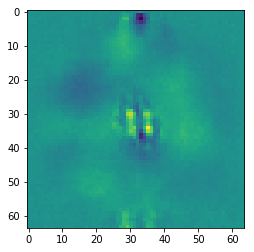

-0.51508385 0.48986736
Noisy


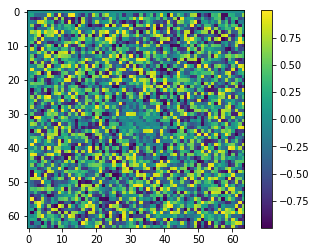

-0.9989247697000199 0.9997630711550647
Pristine


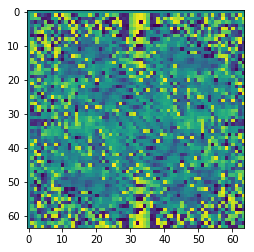

-0.9989718042359058 0.9980202284716032
************** i =  7
Predicted


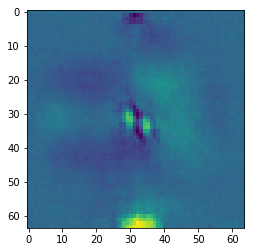

-0.29365927 0.5640045
Noisy


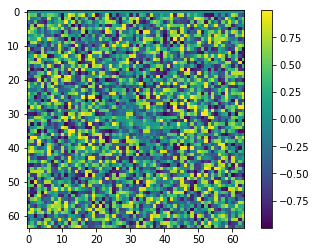

-0.9994877510219848 0.9987334057596259
Pristine


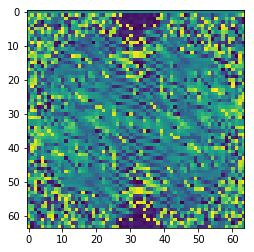

-0.9987861752818694 0.9989535817706879
************** i =  8
Predicted


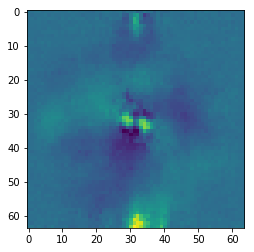

-0.35301775 0.60546255
Noisy


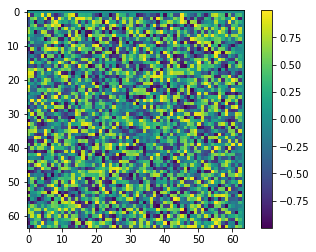

-0.9999405524358236 0.9987125156684458
Pristine


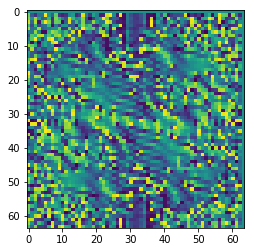

-0.9994607831878397 0.9982828753311562
************** i =  9
Predicted


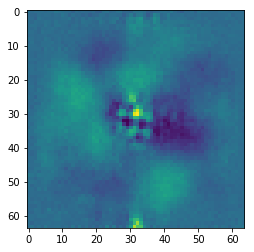

-0.2623647 0.47384423
Noisy


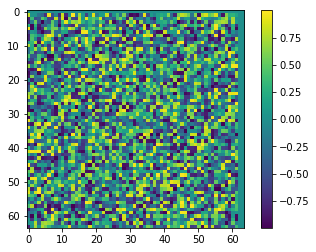

-0.9990085186512301 0.9999940445041338
Pristine


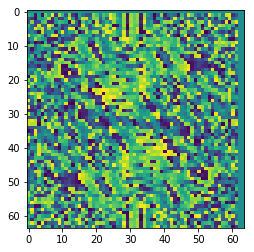

-0.9998283223912967 0.9998331844202152
************** i =  10
Predicted


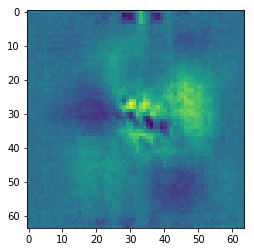

-0.2052268 0.34348845
Noisy


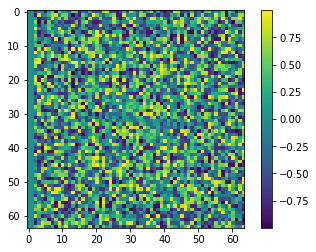

-0.9998528541615196 0.99821920067018
Pristine


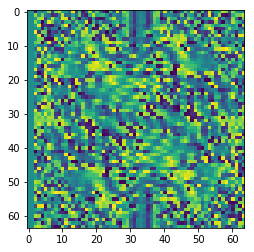

-0.9994468703076602 0.9997513361402012
************** i =  11
Predicted


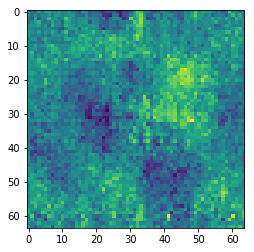

-0.110078335 0.12447226
Noisy


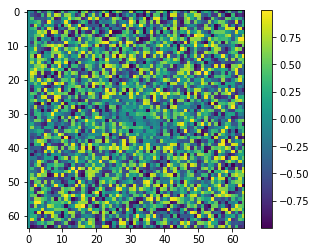

-0.9992215883754098 0.9965940435927793
Pristine


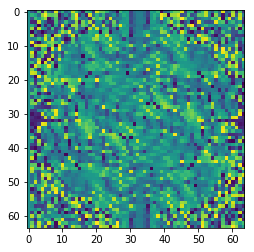

-0.9990348252445531 0.9982975451223364


In [5]:
def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))

model = load_model('best_phase')
test_dir = '/home/tkyono/Desktop/bispectrum_training/validate/bispec_training_validation_20180820.mat_ensemble_1_of_1.mat.h5'

Xr = []
Xi = []
Yr = []
Yi = []
hdf5 = h5py.File(test_dir, 'r')
batch_size = 8
j = 0
F1Xi = hdf5['Degraded_amplitude'][j:j + batch_size]
print(F1Xi.shape)
F1Xi = np.reshape(F1Xi, (batch_size,25, 64,64, 1))
#print(F1Xi.shape)
F1Xr = hdf5['Degraded_phase'][j:j + batch_size]
F1Xr = np.reshape(F1Xr,(batch_size,25, 64,64, 1))
F1Yi = hdf5['Pristine_amplitude'][j:j + batch_size]
F1Yi = np.reshape(F1Yi,(batch_size,25, 64,64, 1))
F1Yr = hdf5['Pristine_phase'][j:j + batch_size]
F1Yr = np.reshape(F1Yr, (batch_size,25, 64,64, 1))
#F1Xr = np.moveaxis(F1Xr, 1, 4)
for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i])) 
#F1Yr = np.moveaxis(F1Yr, 1, 4)
for i in range(len(F1Yr)):
    Yr.append(normalize(F1Yr[i]))
#F1Xi = np.moveaxis(F1Xi, 1, 4)
for i in range(len(F1Xi)):
    Xi.append(normalize(F1Xi[i]))
#F1Yi = np.moveaxis(F1Yi, 1, 4)
for i in range(len(F1Yi)):
    Yi.append(normalize(F1Yi[i]))
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi)
        
Xr = np.array(Xr)[:,:12,:,:]    
Yr = np.array(Yr)[:,:12,:,:]     
Xi = np.array(Xi)[:,:12,:,:]      
Yi = np.array(Yi)[:,:12,:,:]    
F1Xr = []
F1Yr = []
F1Xi = []
F1Yi = []
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi) 


import matplotlib.pyplot as plt


Ypred = model.predict(Xr)
print(Ypred.shape)
print(np.max(Ypred))
for i in range(12):
    print("************** i = ", i)
    print("Predicted")
    plt.imshow(np.squeeze(Ypred[0,i,:,:]))
    plt.show()
    print(np.min(Ypred[0,i,:,:]),np.max(Ypred[0,i,:,:]))
    
    #print("Predicted - Noisy")
    #plt.imshow(Ypred[i,3,:,:,1] - Xr[i,3,:,:,1])
    #plt.show()

    #print("Predicted - Pristine")
    #plt.imshow(Ypred[i,3,:,:,1] - Yr[i,3,:,:,1])
    #plt.show()


    print("Noisy")
    plt.imshow(np.squeeze(Xr[0,i,:,:]))
    plt.colorbar()
    plt.show()
    print(np.min(Xr[0,i,:,:]),np.max(Xr[0,i,:,:]))
    print("Pristine")
    plt.imshow(np.squeeze(Yr[0,i,:,:]))
    plt.show()
    print(np.min(Yr[0,i,:,:]),np.max(Yr[0,i,:,:]))

(8, 5, 5, 64, 64)
(8, 12, 64, 64, 1)
0.8895401
************** i =  0
Predicted


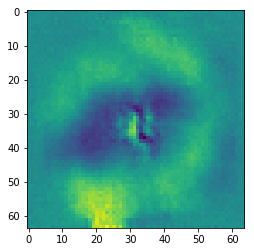

-0.31730676 0.32190204
Noisy


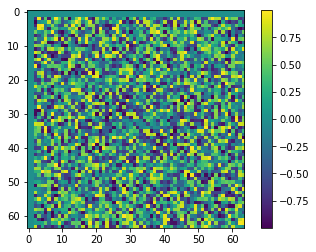

-0.9994002958127335 0.9988273853474446
Pristine


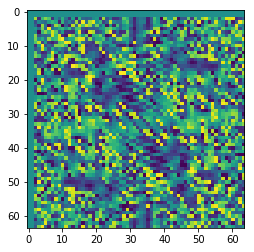

-0.99820599546141 0.9992468766889883
************** i =  1
Predicted


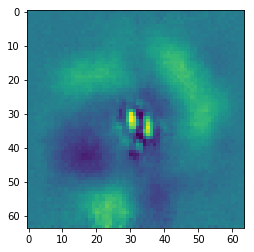

-0.29648918 0.41455042
Noisy


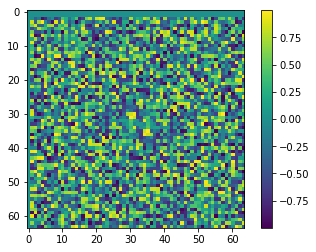

-0.9994894492098997 0.9993869443339941
Pristine


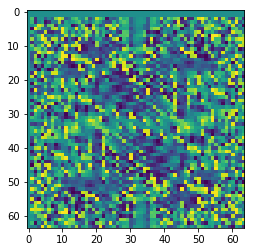

-0.9955055620296199 0.9986059924638897
************** i =  2
Predicted


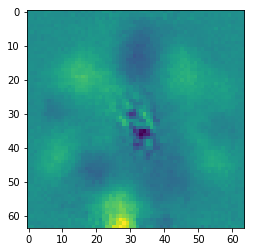

-0.40190566 0.4114197
Noisy


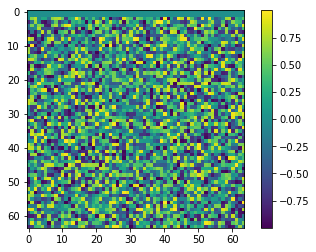

-0.9993394396343458 0.9999678774093763
Pristine


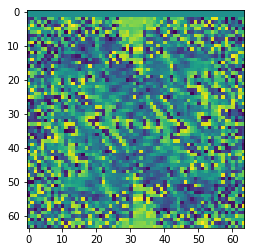

-0.9989650785511104 0.9994979771395364
************** i =  3
Predicted


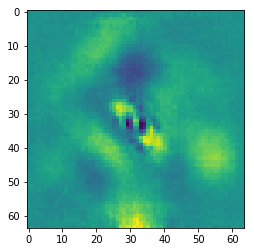

-0.3910954 0.3769532
Noisy


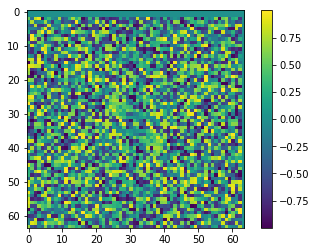

-0.9999051255310127 0.9996322727141485
Pristine


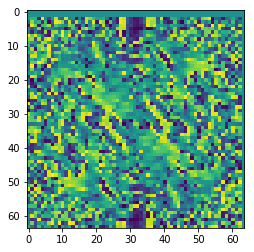

-0.9987512197561448 0.997993098292674
************** i =  4
Predicted


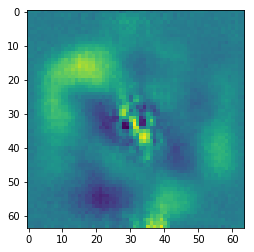

-0.3016953 0.40328133
Noisy


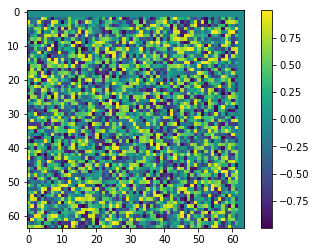

-0.999042493880544 0.9999172168053555
Pristine


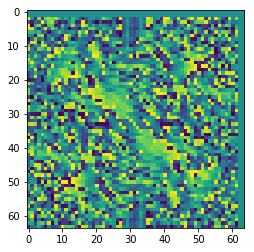

-0.9990927909385451 0.9984343048312302
************** i =  5
Predicted


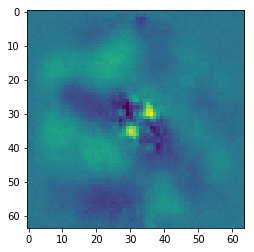

-0.34861413 0.54435337
Noisy


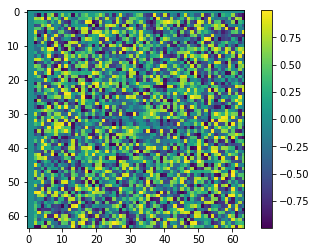

-0.9983448173644331 0.9979490947068229
Pristine


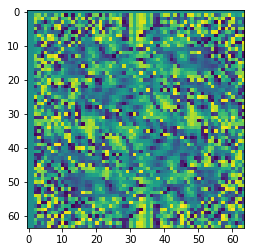

-0.9989423881516941 0.9992355953381419
************** i =  6
Predicted


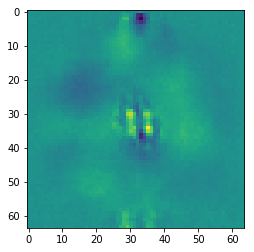

-0.51508385 0.48986736
Noisy


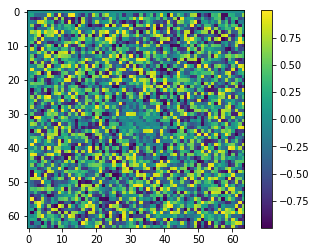

-0.9989247697000199 0.9997630711550647
Pristine


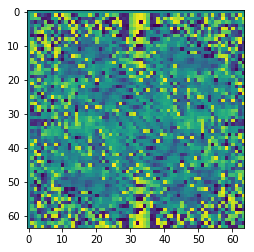

-0.9989718042359058 0.9980202284716032
************** i =  7
Predicted


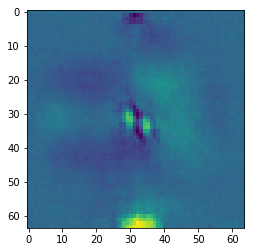

-0.29365927 0.5640045
Noisy


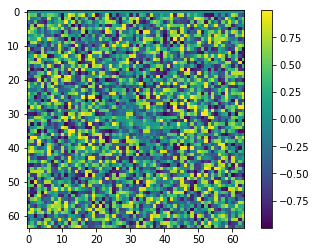

-0.9994877510219848 0.9987334057596259
Pristine


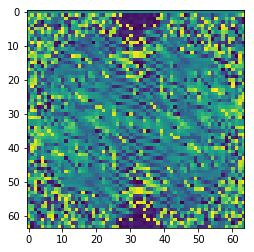

-0.9987861752818694 0.9989535817706879
************** i =  8
Predicted


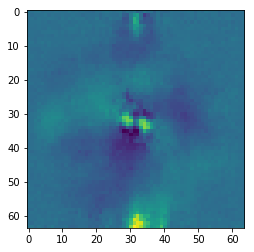

-0.35301775 0.60546255
Noisy


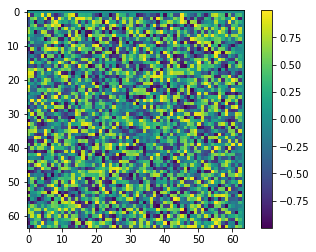

-0.9999405524358236 0.9987125156684458
Pristine


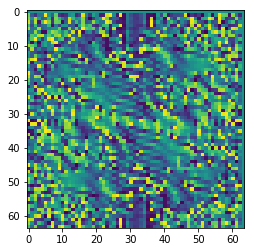

-0.9994607831878397 0.9982828753311562
************** i =  9
Predicted


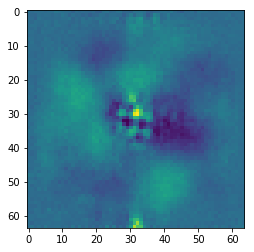

-0.2623647 0.47384423
Noisy


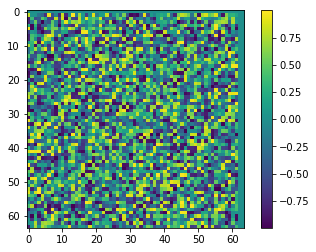

-0.9990085186512301 0.9999940445041338
Pristine


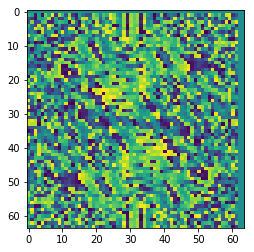

-0.9998283223912967 0.9998331844202152
************** i =  10
Predicted


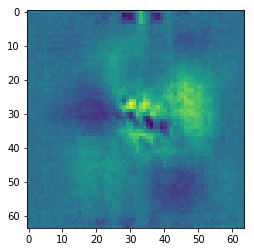

-0.2052268 0.34348845
Noisy


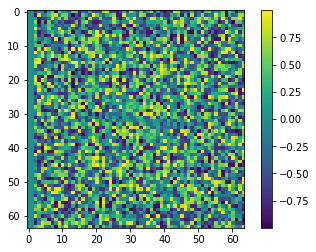

-0.9998528541615196 0.99821920067018
Pristine


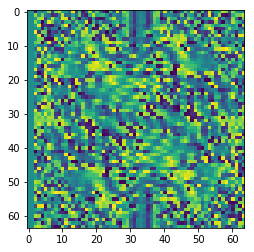

-0.9994468703076602 0.9997513361402012
************** i =  11
Predicted


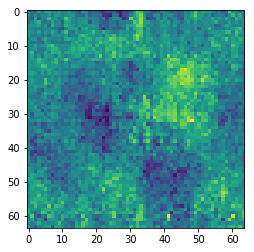

-0.110078335 0.12447226
Noisy


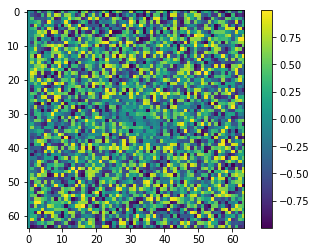

-0.9992215883754098 0.9965940435927793
Pristine


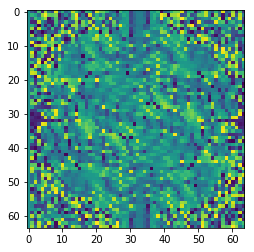

-0.9990348252445531 0.9982975451223364


In [6]:
def normalize(A):
    return A
    #return (A - np.min(A)) / (np.max(A) - np.min(A))
def standardize(A): 
    return normalize((A - np.mean(A)) / np.std(A))

model = load_model('best_phase')
test_dir = '/home/tkyono/Desktop/bispectrum_training/validate/bispec_training_validation_20180820.mat_ensemble_1_of_1.mat.h5'

Xr = []
Xi = []
Yr = []
Yi = []
hdf5 = h5py.File(test_dir, 'r')
batch_size = 8
j = 0
F1Xi = hdf5['Degraded_amplitude'][j:j + batch_size]
print(F1Xi.shape)
F1Xi = np.reshape(F1Xi, (batch_size,25, 64,64, 1))
#print(F1Xi.shape)
F1Xr = hdf5['Degraded_phase'][j:j + batch_size]
F1Xr = np.reshape(F1Xr,(batch_size,25, 64,64, 1))
F1Yi = hdf5['Pristine_amplitude'][j:j + batch_size]
F1Yi = np.reshape(F1Yi,(batch_size,25, 64,64, 1))
F1Yr = hdf5['Pristine_phase'][j:j + batch_size]
F1Yr = np.reshape(F1Yr, (batch_size,25, 64,64, 1))
#F1Xr = np.moveaxis(F1Xr, 1, 4)
for i in range(len(F1Xr)):
    Xr.append(normalize(F1Xr[i])) 
#F1Yr = np.moveaxis(F1Yr, 1, 4)
for i in range(len(F1Yr)):
    Yr.append(normalize(F1Yr[i]))
#F1Xi = np.moveaxis(F1Xi, 1, 4)
for i in range(len(F1Xi)):
    Xi.append(normalize(F1Xi[i]))
#F1Yi = np.moveaxis(F1Yi, 1, 4)
for i in range(len(F1Yi)):
    Yi.append(normalize(F1Yi[i]))
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi)
        
Xr = np.array(Xr)[:,:12,:,:]    
Yr = np.array(Yr)[:,:12,:,:]     
Xi = np.array(Xi)[:,:12,:,:]      
Yi = np.array(Yi)[:,:12,:,:]    
F1Xr = []
F1Yr = []
F1Xi = []
F1Yi = []
Xr = np.array(Xr)    
Yr = np.array(Yr)    
Xi = np.array(Xi)    
Yi = np.array(Yi) 


import matplotlib.pyplot as plt


Ypred = model.predict(Xr)
print(Ypred.shape)
print(np.max(Ypred))
for i in range(12):
    print("************** i = ", i)
    print("Predicted")
    plt.imshow(np.squeeze(Ypred[0,i,:,:]))
    plt.show()
    print(np.min(Ypred[0,i,:,:]),np.max(Ypred[0,i,:,:]))
    
    #print("Predicted - Noisy")
    #plt.imshow(Ypred[i,3,:,:,1] - Xr[i,3,:,:,1])
    #plt.show()

    #print("Predicted - Pristine")
    #plt.imshow(Ypred[i,3,:,:,1] - Yr[i,3,:,:,1])
    #plt.show()


    print("Noisy")
    plt.imshow(np.squeeze(Xr[0,i,:,:]))
    plt.colorbar()
    plt.show()
    print(np.min(Xr[0,i,:,:]),np.max(Xr[0,i,:,:]))
    print("Pristine")
    plt.imshow(np.squeeze(Yr[0,i,:,:]))
    plt.show()
    print(np.min(Yr[0,i,:,:]),np.max(Yr[0,i,:,:]))

In [ ]:


hf = h5py.File('predicted_phase.h5', 'w')
hf.create_dataset('phase', data = Ypred)
hf.close()